In [ ]:
import torch
import math
import numpy as np 
from scipy.stats import multivariate_normal
from matplotlib import pyplot as plt 

# torch.manual_seed(1)            
# np.random.seed(1)



Text(0.5, 1.0, 'Target distribution with randomly initialized gaussians')

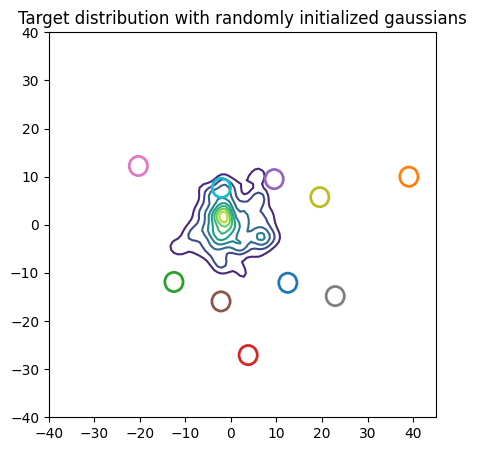

In [27]:




### TARGET DEFINITION 
N_target = 100
d = 2
epsilon = math.sqrt(d)

sig = torch.eye(d) * 5**2
mvn_dist = torch.distributions.MultivariateNormal(torch.zeros(d), covariance_matrix=sig)
pi_mean = mvn_dist.sample((N_target,))
pi_cov = torch.eye(d)*epsilon**2

p_dist = [multivariate_normal(mean=mean, cov=pi_cov) for mean in pi_mean]
x = np.linspace(-40, 40, 100)
y = np.linspace(-40, 40, 100)
X, Y = np.meshgrid(x, y)
pos = np.dstack((X, Y))
Z = np.dstack([p.pdf(pos)/N_target for p in p_dist]).sum(axis = -1)



plt.figure(figsize=(5,5))
plt.contour(X, Y, Z, levels=10, cmap="viridis")


N_mixture = 10
d = 2    
epsilon = math.sqrt(d)

sig = torch.eye(d) * 15**2
mvn_dist = torch.distributions.MultivariateNormal(torch.zeros(d), covariance_matrix=sig)
mu_locs = mvn_dist.sample((N_mixture,))
cov_mixture = torch.eye(d)*epsilon**2
colors = plt.cm.tab10(range(N_mixture))  # Assign unique colors for each mean

for i,mean in enumerate(mu_locs):
    ellipse = plt.Circle(mean, epsilon**2, color=colors[i], fill=False, linewidth=2,  zorder=10)
    plt.gca().add_patch(ellipse)


plt.title("Target distribution with randomly initialized gaussians")


  0%|          | 0/1000 [00:00<?, ?it/s]

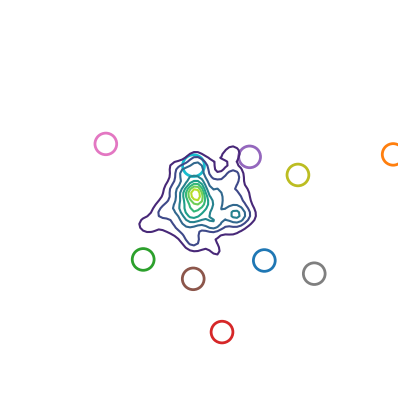

  0%|          | 2/1000 [00:00<06:01,  2.76it/s]

Iteration 0, KL divergence: 27.72738265991211


 10%|█         | 100/1000 [00:21<03:36,  4.15it/s]

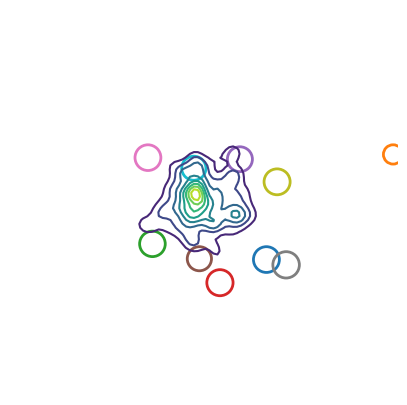

 10%|█         | 101/1000 [00:21<04:52,  3.08it/s]

Iteration 100, KL divergence: 12.38005256652832


 20%|██        | 200/1000 [00:38<02:18,  5.78it/s]

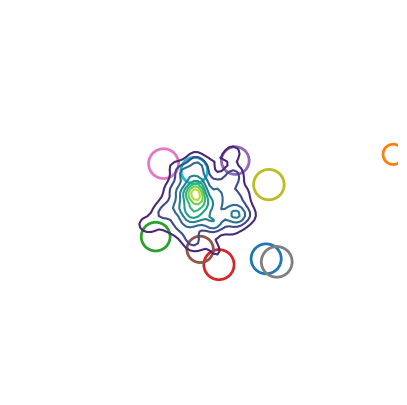

 20%|██        | 201/1000 [00:39<03:51,  3.46it/s]

Iteration 200, KL divergence: 10.29335880279541


 30%|███       | 300/1000 [00:57<02:04,  5.60it/s]

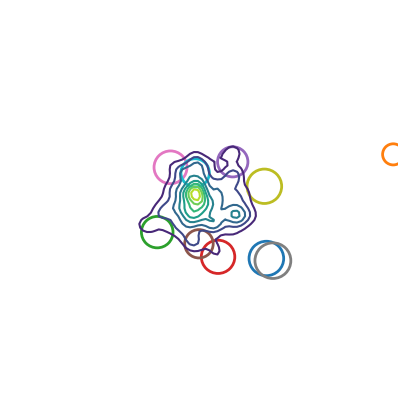

 30%|███       | 301/1000 [00:57<03:14,  3.60it/s]

Iteration 300, KL divergence: 9.76346206665039


 40%|████      | 400/1000 [01:14<01:33,  6.45it/s]

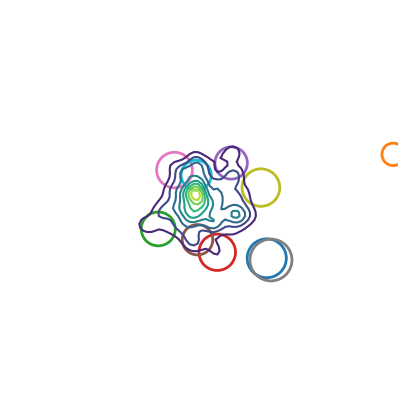

 40%|████      | 402/1000 [01:14<02:10,  4.59it/s]

Iteration 400, KL divergence: 9.605669975280762


 50%|█████     | 500/1000 [01:32<01:34,  5.30it/s]

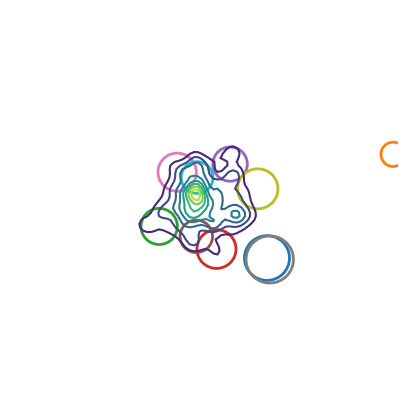

 50%|█████     | 502/1000 [01:32<02:02,  4.07it/s]

Iteration 500, KL divergence: 9.451241493225098


 60%|██████    | 600/1000 [01:50<01:04,  6.19it/s]

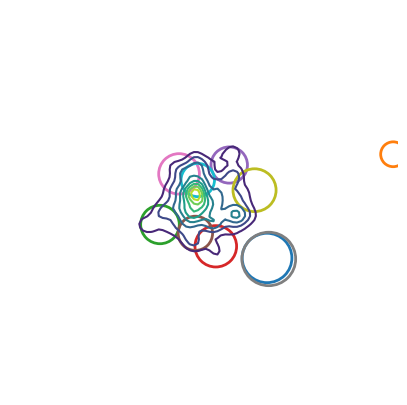

 60%|██████    | 602/1000 [01:50<01:29,  4.45it/s]

Iteration 600, KL divergence: 9.296391487121582


 70%|███████   | 700/1000 [02:06<00:51,  5.77it/s]

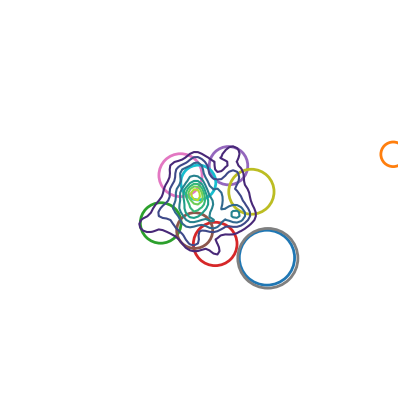

 70%|███████   | 702/1000 [02:07<01:12,  4.11it/s]

Iteration 700, KL divergence: 9.353189468383789


 80%|████████  | 800/1000 [02:23<00:29,  6.72it/s]

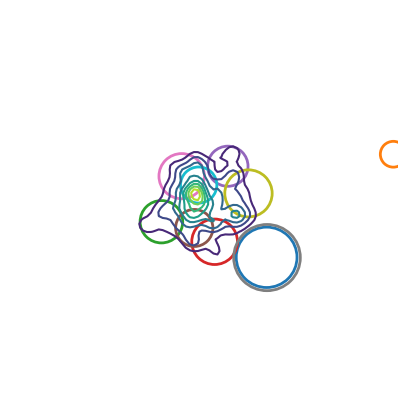

 80%|████████  | 801/1000 [02:24<00:47,  4.22it/s]

Iteration 800, KL divergence: 9.219791412353516


 90%|█████████ | 900/1000 [02:39<00:17,  5.80it/s]

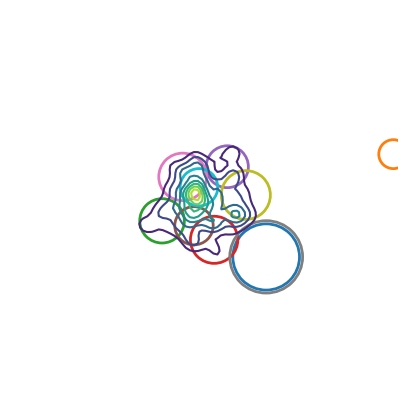

 90%|█████████ | 902/1000 [02:40<00:23,  4.14it/s]

Iteration 900, KL divergence: 9.131793022155762


100%|█████████▉| 999/1000 [02:56<00:00,  5.87it/s]

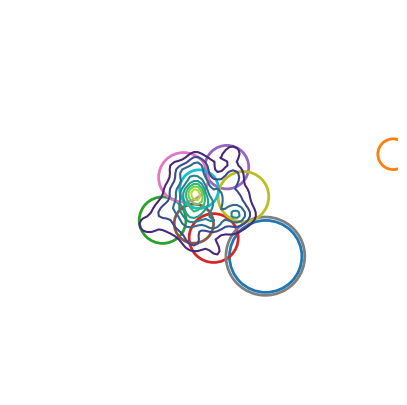

100%|██████████| 1000/1000 [02:57<00:00,  5.64it/s]

Iteration 999, KL divergence: 9.058884620666504


In [30]:
from src.optim import gradient_descent_mu_epsi

### new positions of x_i, evolution of the KL, evolution of x_i, new values for epsilon, evolution of the values for espilon 
new_mu_locs, kls, means, new_epsilon, E = gradient_descent_mu_epsi(mu_locs, torch.ones(N_mixture)*1.5 , pi_mean, pi_cov, learning_rate_mu=0.01*d,learning_rate_eps=0.01*d, num_iterations=1000)


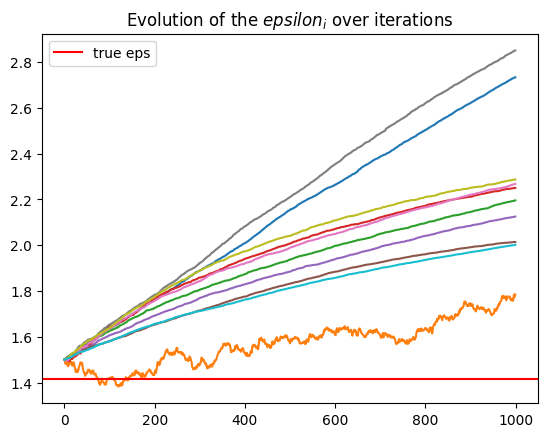

In [31]:
for i in range(N_mixture):
    plt.plot(torch.stack(E)[:,i] , color = colors[i])
plt.axhline(y = math.sqrt(d), color='r', linestyle='-',label = "true eps")
plt.title("Evolution of the $epsilon_i$ over iterations")
plt.legend()

In [38]:
pi_mean.shape

torch.Size([100, 2])

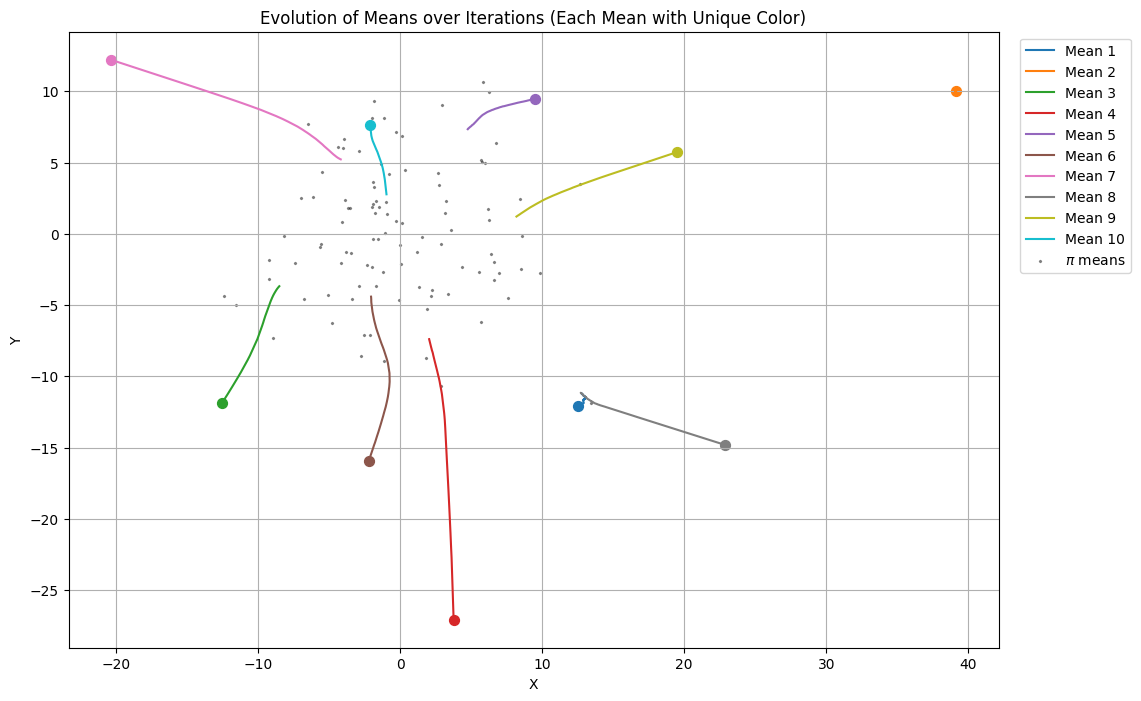

In [46]:

MEANS = torch.stack(means).detach()
iterations, num_means, dimensions = MEANS.shape

plt.figure(figsize=(12, 8))

for i in range(num_means):
    x_values = MEANS[:, i, 0].numpy() 
    y_values = MEANS[:, i, 1].numpy() 

    plt.plot(x_values, y_values, color=colors[i], label=f'Mean {i+1}')
    plt.scatter(x_values[0], y_values[0], color=colors[i], s=50, marker='o')


plt.scatter(pi_mean[:,0], pi_mean[:,1], color = "black", alpha = 0.5, marker = "x", s = 2, label = "$\pi$ means")
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Evolution of Means over Iterations (Each Mean with Unique Color)")
plt.legend(loc="upper right", bbox_to_anchor=(1.15, 1))
plt.grid(True)
plt.show()

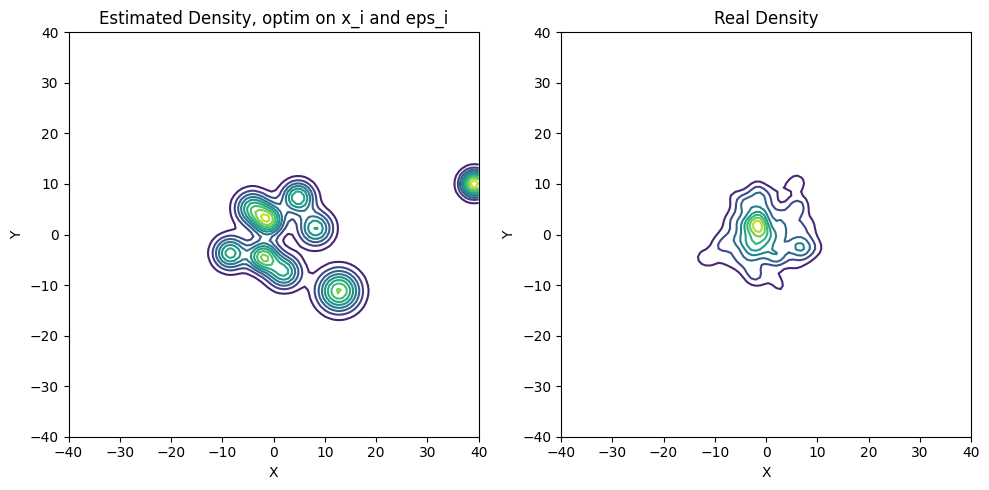

In [36]:
estimated_mu_sig = [multivariate_normal(mean=mean, cov=torch.eye(d).numpy()*epsi**2) for mean, epsi in zip(new_mu_locs.detach().numpy(), new_epsilon.detach().numpy())]
p_dist = [multivariate_normal(mean=mean, cov=pi_cov) for mean in pi_mean]

# Generate grid
x = np.linspace(-40, 40, 100)
y = np.linspace(-40, 40, 100)
X, Y = np.meshgrid(x, y)
pos = np.dstack((X, Y))

Z_estimated_mu_sig = np.dstack([p.pdf(pos) for p in estimated_mu_sig]).sum(axis=-1) / len(estimated_mu_sig)
Z_real = np.dstack([p.pdf(pos) for p in p_dist]).sum(axis=-1)/N_target

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].contour(X, Y, Z_estimated_mu_sig, levels=10, cmap="viridis")
axes[0].set_title("Estimated Density, optim on x_i and eps_i")
axes[0].set_xlabel("X")
axes[0].set_ylabel("Y")

axes[1].contour(X, Y, Z_real, levels=10, cmap="viridis")
axes[1].set_title("Real Density")
axes[1].set_xlabel("X")
axes[1].set_ylabel("Y")

plt.tight_layout()
plt.show()